In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.

# Импорт библиотек

In [2]:
!pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import os
import random
import string
from copy import deepcopy

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

In [4]:
path_to_folder = "data"
characters = [x if x != "times" else "*" for x in os.listdir(path_to_folder)]
print(characters)

['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']


# Сгенерировать набор текстовых строк из допустимых символов.

In [5]:
def generate_text_dataset(num_lines=100, min_line_length=10, max_line_length=50, characters=None):
    if characters is None:
        characters = string.ascii_letters + string.digits + " "
    dataset = []
    for _ in range(num_lines):
        line_length = random.randint(min_line_length, max_line_length)
        line = "".join(random.choices(characters, k=line_length))
        dataset.append(line)
    return dataset

In [21]:
generated_strings = generate_text_dataset(num_lines=10, min_line_length=10, max_line_length=20, characters=characters)
for str_ in generated_strings:
    print(str_)

0(t(yh1X93h+,h7t3
34wyy5,6t4764y530-
*-yy,7y5,58
ytX3-,yyt-wh*+(
1(*+4yw293)yh0X89
*+*)77t816-h+1w13h7
Xw6y0X+-(7452)281
8*860202(y3h6*3
7t5X7+h)1X,+w
X)2546w66)5,X3th


# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.

In [7]:
def get_random_path_to_image(charachter):
    return os.path.join(path_to_folder, charachter if charachter != "*" else "times", random.choice(os.listdir(os.path.join(path_to_folder, charachter if charachter != "*" else "times"))))

In [22]:
images_str = dict()
for str_ in generated_strings:
    images_path = []
    for chr in str_:
        images_path.append(get_random_path_to_image(chr))
    images_str[str_] = images_path

In [23]:
images_str

{'0(t(yh1X93h+,h7t3': ['data\\0\\0_100328.jpg',
  'data\\(\\(_46120.jpg',
  'data\\t\\exp93612.jpg',
  'data\\(\\exp85956.jpg',
  'data\\y\\exp21597.jpg',
  'data\\h\\H_82938.jpg',
  'data\\1\\1_46253.jpg',
  'data\\X\\exp25299.jpg',
  'data\\9\\9_452.jpg',
  'data\\3\\3_51903.jpg',
  'data\\h\\exp75377.jpg',
  'data\\+\\+_74911.jpg',
  'data\\,\\exp36532.jpg',
  'data\\h\\h_88061.jpg',
  'data\\7\\exp2289.jpg',
  'data\\t\\t_96579.jpg',
  'data\\3\\3_65804.jpg'],
 '34wyy5,6t4764y530-': ['data\\3\\exp3281.jpg',
  'data\\4\\4_21985.jpg',
  'data\\w\\exp32814.jpg',
  'data\\y\\exp34341.jpg',
  'data\\y\\exp34257.jpg',
  'data\\5\\5_54201.jpg',
  'data\\,\\exp62522.jpg',
  'data\\6\\exp37253.jpg',
  'data\\t\\exp96776.jpg',
  'data\\4\\exp3668.jpg',
  'data\\7\\7_53529.jpg',
  'data\\6\\6_81393.jpg',
  'data\\4\\exp55716.jpg',
  'data\\y\\exp1235.jpg',
  'data\\5\\exp58664.jpg',
  'data\\3\\exp38965.jpg',
  'data\\0\\exp54478.jpg',
  'data\\-\\exp12857.jpg'],
 '*-yy,7y5,58': ['data\\times

In [24]:
IMAGE_SIZE = 45

def images_char_to_image_str(list_of_images):
    margin = 20
    image = Image.new("RGB", (len(list_of_images) * (IMAGE_SIZE + margin), IMAGE_SIZE * 2), (255, 255, 255))
    
    for k, image_ in enumerate(list_of_images):
        image.paste(image_, (k * (IMAGE_SIZE + margin), IMAGE_SIZE // 2))
    
    return image

In [25]:
images_pil = dict()
for key, value in images_str.items():
    images_ = []
    for p in value:
        images_.append(Image.open(p).convert("RGB"))
    images_pil[key] = images_
images_pil

{'0(t(yh1X93h+,h7t3': [<PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>],
 '34wyy5,6t4764y530-': [<PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Ima

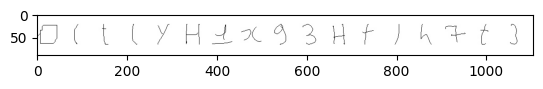

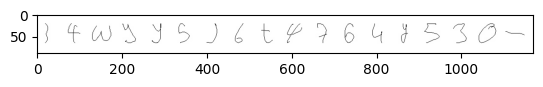

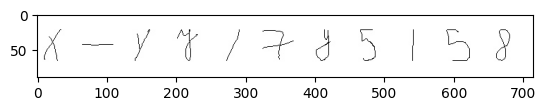

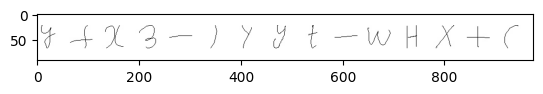

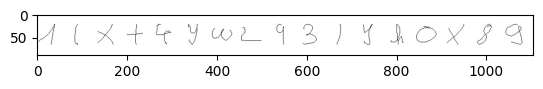

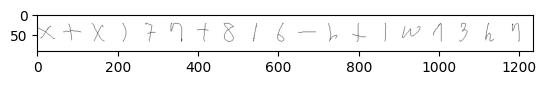

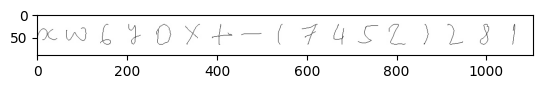

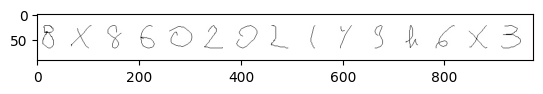

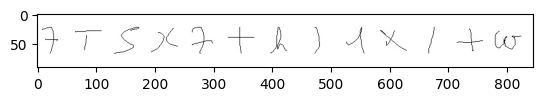

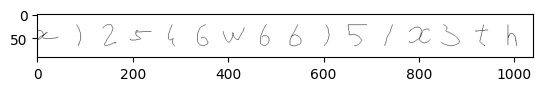

In [26]:
for key, value in images_pil.items():
    plt.imshow(images_char_to_image_str(value))
    plt.show()

# КЛАССИФИКАЦИЯ (k ближайших соседей)

# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.

In [13]:
MAX_CHAR_PER_CLASS = 3000

data = []
target = []
for chr in characters:
    orig_chr = chr if chr != "*" else "times"
    chr_dir = os.listdir(os.path.join(path_to_folder, orig_chr))
    random_images = random.sample(chr_dir, min(MAX_CHAR_PER_CLASS, len(chr_dir)))
    for random_image in random_images:
        try:
            image = Image.open(os.path.join(path_to_folder, orig_chr, random_image)).convert("RGB")
            data.append(np.array(image).flatten())
            target.append(chr)
        except Exception:
            pass
        
print(data)
print(target)


# for key, value in images_pil.items():
#     for chr, image in zip(list(key), value):
#         data.append(np.array(image).flatten())
#         target.append(chr)
# print(data)
# print(target)

[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=14)

# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [15]:
param_grid = {"n_neighbors": [i for i in range(1, 5 + 1)]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'n_neighbors': 1}

In [16]:
model = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"])
model.fit(X_train, y_train)
accuracy_list = []
predicted = model.predict(X_test)
print(f"Mean accuracy on test set: {accuracy_score(predicted, y_test)}")

Mean accuracy on test set: 0.8360227170287569


# РАСПОЗНАВАНИЕ

In [17]:
def resize_to_normal(image):
    width, height = image.size

    new_image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), (255, 255, 255))
    new_image.paste(image, ((IMAGE_SIZE - width) // 2, (IMAGE_SIZE - height) // 2))

    return new_image

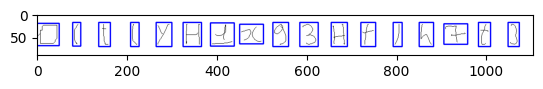

0(t(yh1X93h+,h7t3 ['2' '(' '1' '(' 'y' '-' '1' ',' '9' '+' 'h' '(' ',' 'h' '1' '(' ')']


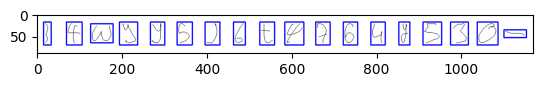

34wyy5,6t4764y530- ['h' '4' 'w' '(' '1' '-' ')' '6' 't' '-' ')' '3' '4' ',' '5' '3' '0' '-']


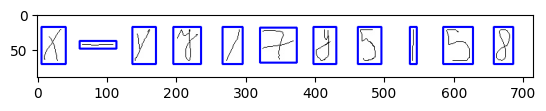

*-yy,7y5,58 [',' '-' '-' ')' ',' '7' ')' '0' ',' '5' '8']


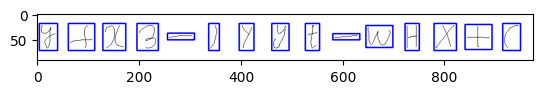

ytX3-,yyt-wh*+( ['y' 't' ',' '3' '-' ',' ',' ',' '1' '-' 'w' '1' '*' '+' '(']


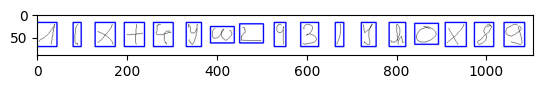

1(*+4yw293)yh0X89 ['1' '(' ',' '-' '4' ')' 't' '2' 'y' '3' ')' '1' 'h' '0' '(' ')' '-']


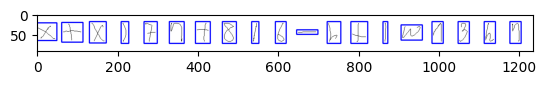

*+*)77t816-h+1w13h7 [',' '-' ',' ')' '7' '7' 't' '5' ',' '(' '-' 'h' '1' ',' 'w' '1' ')' 'h'
 ')']


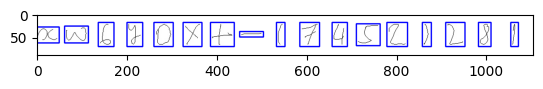

Xw6y0X+-(7452)281 ['t' 'w' '(' 'y' '(' ',' '+' '-' '(' '7' ')' '(' '2' ')' '(' '8' '1']


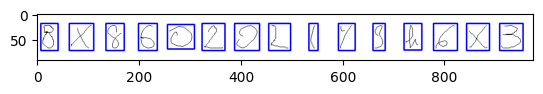

8*860202(y3h6*3 ['3' '*' ',' '6' '0' ',' '0' '(' '(' ',' '1' '(' '6' ',' '3']


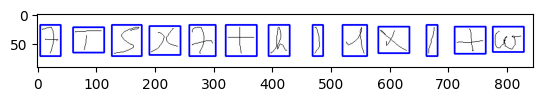

7t5X7+h)1X,+w ['7' 't' '5' ',' ')' '(' 'h' ')' '1' 't' ',' '1' '-']


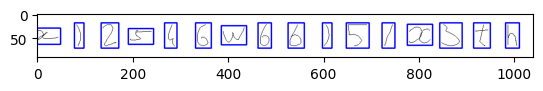

X)2546w66)5,X3th ['-' ')' '2' 't' '(' ',' 'w' '6' ',' ')' '5' 'y' ')' '3' 't' 'h']
Mean accuracy on recognition set: 0.5282845392481615


In [27]:
accuracy_list = []
solution = dict()
for key, value in images_pil.items():
    pil_image = images_char_to_image_str(images_pil[key])
    image = np.array(pil_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 12)
    gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
    gray = cv2.bitwise_not(gray)

    contours, _ = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, 2)
    boundings = sorted([cv2.boundingRect(c_) for c_ in contours], key=lambda x: x[0])

    vectors = []
    for bound in boundings:
        x, y, w, h = bound
        img = image[y:y+h, x:x+w]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        vectors.append(np.array(resize_to_normal(Image.fromarray(img))).flatten())

    plt.imshow(image)
    plt.show()

    predicted = model.predict(vectors)
    print(key, predicted)
    solution[key] = predicted
    accuracy_list.append(accuracy_score(predicted, list(key)))

print(f"Mean accuracy on recognition set: {np.mean(accuracy_list)}")

# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.

In [63]:
def str_random_change(list_str_):
    delete_str_ = [chr for chr in list_str_ if random.random() > 0.1]
    modify_string = deepcopy(list_str_)
    for i in range(len(delete_str_)):
        if random.random() < 0.1:
            rand_chr = random.choice(characters)
            modify_string.insert(i, rand_chr)
    return modify_string

In [65]:
def cer_metric(original, predicted):
    errors = sum(1 for orig, pred in zip(original, predicted) if orig != pred)
    errors += abs(len(original) - len(predicted))
    return errors / len(original) if len(original) > 0 else 0 

In [68]:
cer = 0
for key in solution.keys():
    temp_1 = list(solution[key])
    temp_2 = str_random_change(temp_1)
    temp_1 = "".join(temp_1)
    temp_2 = "".join(temp_2)
    metric = cer_metric(temp_1, temp_2)
    cer += metric
    print(temp_1, temp_2, metric)

print(f"MEAN CER: {cer / len(solution)}")

2(1(y-1,9+h(,h1() 2(1(9y-1,9+h(,h1() 0.8235294117647058
h4w(1-)6t-)34,530- h4w,(1)-)6t-)34,530- 0.8888888888888888
,--),7)0,58 ,--),7)0,58 0.0
yt,3-,,,1-w1*+( yt,3-,,,1w-w1*+( 0.4666666666666667
1(,-4)t2y3)1h0()- 1X(,-4)+0t2y33)1h0()- 1.1764705882352942
,-,)77t5,(-h1,w1)h) ,-,)77t5,(-h1,w1)h) 0.0
tw(y(,+-(7)(2)(81 tw(y(,+-(97)(02)5(81 0.6470588235294118
3*,60,0((,1(6,3 3*,60,01((,1(6,3 0.5333333333333333
7t5,)(h)1t,1- 7t5,7)(h)1t,1- 0.7692307692307693
-)2t(,w6,)5y)3th -)2t(,w6X,),5y)3th 0.625
MEAN CER: 0.593017848164907
